<a href="https://colab.research.google.com/github/IsraelPeled/Image-Colorization/blob/main/GreyToColorCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **the dataset that we used in this project:**
[https://www.kaggle.com/datasets/theblackmamba31/landscape-image-colorization](https://www.kaggle.com/datasets/theblackmamba31/landscape-image-colorization)

In [2]:
! unzip -q "/content/drive/MyDrive/Deep Learning/GreyToColor/archive.zip" -d './'

#**Imports**

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
from tqdm.notebook import tqdm

In [4]:
MANUAL_SEED = 42
BATCH_SIZE = 32
SHUFFLE = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


#**Data Preparation**

For the data preparation phase, We created a custom dataset using PyTorch’s `Dataset` class, called `LandscapeDataset`. This dataset loads images from a directory and applies transformations to them. The dataset includes images in both color and grayscale, where the goal is to use the grayscale images as input and predict the corresponding color images.

### Dataset Creation

The `LandscapeDataset` class is initialized with a transformation function, and it loads the images from two subdirectories: `color` for color images and `gray` for grayscale images. The images are read using `read_image` from `torchvision`, and their pixel values are normalized by dividing them by 255.


In [5]:
class LandscapeDataset(Dataset):
    def __init__(self, transform=None):
        self.dataroot = "./landscape Images"
        self.images = os.listdir(f'{self.dataroot}/color')
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get image Paths
        img_path = self.images[idx]

        # Load the images
        color_img = read_image(f'{self.dataroot}/color/{img_path}') / 255
        gray_img = read_image(f'{self.dataroot}/gray/{img_path}') / 255

        if self.transform:
            color_img = self.transform(color_img)
            gray_img = self.transform(gray_img)

        return color_img, gray_img

### Image Transformation

For the image transformation, we used `torchvision.transforms.Compose` to apply resizing, specifically scaling each image to a size of 150x150 pixels.

After creating the dataset, we split it into training, validation, and test sets with proportions of 70%, 15%, and 15%, respectively. This was done using the `random_split` method from PyTorch’s `torch.utils.data`.

Finally, we created separate data loaders for each split using PyTorch’s `DataLoader` to handle batching and shuffling during training and evaluation.

In [6]:
transform = transforms.Compose([
    transforms.Resize((150, 150), antialias=False),
])

dataset = LandscapeDataset(transform=transform)

train_set, val_set, test_set = random_split(dataset, [0.7, 0.15, 0.15], generator=torch.Generator().manual_seed(MANUAL_SEED))

trainloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
valloader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
testloader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE)

### Displaying Sample Images

To visualize the images and ensure that the data preprocessing steps are correctly applied, we wrote a function `show_images` to display sample grayscale and color images. This allows us to inspect the data being passed to the model during training.

The function `show_images` takes two inputs: the color images and the corresponding grayscale images. It uses `matplotlib` to display the images in a 5x2 grid, where each row contains one grayscale image and one color image.

The images are displayed by first converting the tensor dimensions to `(height, width, channels)` using the `permute` function and then converting the tensor to a NumPy array to be compatible with `matplotlib`. The grayscale images are displayed using a grayscale colormap, while the color images are displayed in their natural color.


In [7]:
def show_images(color, gray):
    fig, axs = plt.subplots(5, 2, figsize=(15, 15))
    axs[0, 0].set_title('Grayscale')
    axs[0, 1].set_title('Color')
    for i in range(5):
        axs[i, 0].imshow(gray[i].permute(1,2,0), cmap='gray')
        axs[i, 0].axis('off')
        axs[i, 1].imshow(color[i].permute(1,2,0))
        axs[i, 1].axis('off')
    plt.show()

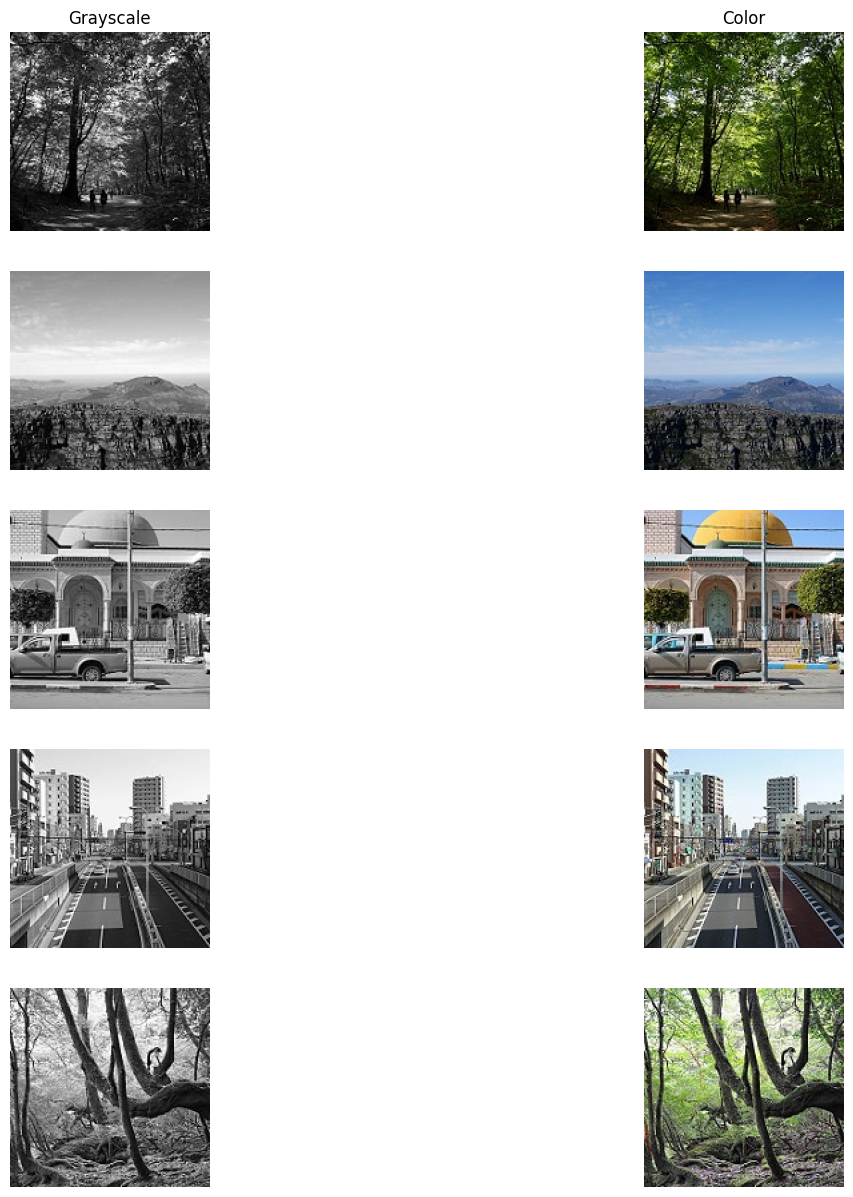

In [8]:
color, gray = next(iter(trainloader))
show_images(color, gray)

#**Model Building:**

### **Model Architecture**

For the image colorization task, we implemented a **ColorAutoEncoder** using a convolutional autoencoder architecture. This type of model is composed of two main parts: the **Encoder** and the **Decoder**.

- **Encoder**: The encoder progressively reduces the spatial dimensions of the input image using convolutional layers. These layers extract important features from the grayscale image (input).
- **Decoder**: The decoder then uses transposed convolutional layers to upsample the encoded features back to the original image size, producing a colorized output.

###**Our Project Architecture:**

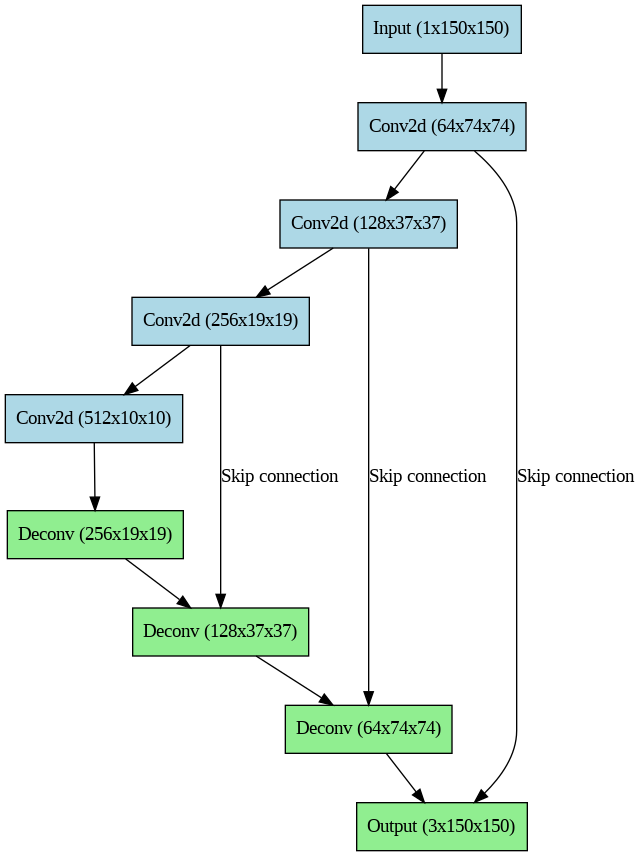

In [9]:
EPOCHS = 10
LEARNING_RATE = 0.001

In [10]:
class ColorAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Input shape: Bx1x150x150


        self.down1 = nn.Conv2d(1, 64, 3, stride=2) # Bx64x74x74
        self.down2 = nn.Conv2d(64, 128, 3, stride=2, padding=1) # Bx128x37x37
        self.down3 = nn.Conv2d(128, 256, 3, stride=2, padding=1) # Bx256x19x19
        self.down4 = nn.Conv2d(256, 512, 3, stride=2, padding=1) # Bx512x10x10

        self.up1 = nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1)
        self.up2 = nn.ConvTranspose2d(512, 128, 3, stride=2, padding=1)
        self.up3 = nn.ConvTranspose2d(256, 64, 3, stride=2, padding=1, output_padding=1)
        self.up4 = nn.ConvTranspose2d(128, 3, 3, stride=2, output_padding=1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Down sample
        d1 = self.relu(self.down1(x))
        d2 = self.relu(self.down2(d1))
        d3 = self.relu(self.down3(d2))
        d4 = self.relu(self.down4(d3))
        # Up sample
        u1 = self.relu(self.up1(d4))
        u2 = self.relu(self.up2(torch.cat((u1,d3), dim=1)))
        u3 = self.relu(self.up3(torch.cat((u2, d2), dim=1)))
        u4 = self.sigmoid(self.up4(torch.cat((u3,d1), dim=1)))

        return u4

#**Training:**

In [11]:
model = ColorAutoEncoder().to(device)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Number of trainable parameters of this model are: {total_params:,}")
print(f'\n{model}')

Total Number of trainable parameters of this model are: 3,470,659

ColorAutoEncoder(
  (down1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2))
  (down2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (down3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (down4): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (up1): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (up2): ConvTranspose2d(512, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (up3): ConvTranspose2d(256, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (up4): ConvTranspose2d(128, 3, kernel_size=(3, 3), stride=(2, 2), output_padding=(1, 1))
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


In [12]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [13]:
def train_loop(trainloader, model, criterion, optimizer):
    running_loss = 0.0
    for idx, (color_img, gray_img) in tqdm(enumerate(trainloader), total=len(trainloader)):
        color_img = color_img.to(device)
        gray_img = gray_img.to(device)

        predictions = model(gray_img)

        optimizer.zero_grad()

        loss = criterion(color_img, predictions)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    return running_loss

In [14]:
def validate_loop(valloader, model, criterion):
    running_loss = 0.0
    with torch.no_grad():
        for idx, (color_img, gray_img) in tqdm(enumerate(valloader), total=len(valloader)):
            color_img = color_img.to(device)
            gray_img = gray_img.to(device)

            predictions = model(gray_img)

            loss = criterion(color_img, predictions)
            running_loss += loss.item()
    return running_loss

In [15]:
for epoch in range(EPOCHS):
    train_loss = train_loop(trainloader, model, criterion, optimizer)
    val_loss = validate_loop(valloader, model, criterion)
    print(f'Epoch: {epoch + 1}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f},')

print('Training And Validate Finished!')

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1, Train Loss: 3.233101, Val Loss: 0.384829,


  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 2, Train Loss: 1.563979, Val Loss: 0.290061,


  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 3, Train Loss: 1.338202, Val Loss: 0.260573,


  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 4, Train Loss: 1.251999, Val Loss: 0.256324,


  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 5, Train Loss: 1.175139, Val Loss: 0.246998,


  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 6, Train Loss: 1.166628, Val Loss: 0.238593,


  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 7, Train Loss: 1.118220, Val Loss: 0.226510,


  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 8, Train Loss: 1.103825, Val Loss: 0.217920,


  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 9, Train Loss: 1.075024, Val Loss: 0.224801,


  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 10, Train Loss: 1.061993, Val Loss: 0.227907,
Training And Validate Finished!


#**Testing:**

In [16]:
total_loss = 0.0
with torch.no_grad():
    for idx, (color_img, gray_img) in tqdm(enumerate(testloader), total=len(testloader)):
        color_img = color_img.to(device)
        gray_img = gray_img.to(device)

        prediction = model(gray_img)

        loss = criterion(prediction, color_img)
        total_loss += loss.item()

print(f"Total Testing loss is: {total_loss/ len(testloader):.3f}")

  0%|          | 0/34 [00:00<?, ?it/s]

Total Testing loss is: 0.007


In [17]:
def show_predictions(color, gray, pred, num):
    fig, axs = plt.subplots(num, 3, figsize=(15, 15))
    axs[0, 0].set_title('Grayscale')
    axs[0, 1].set_title('Color')
    axs[0, 2].set_title('Predicted')
    for i in range(num):
        axs[i, 0].axis('off')
        axs[i, 0].imshow(gray[i].permute(1,2,0), cmap='gray')
        axs[i, 1].axis('off')
        axs[i, 1].imshow(color[i].permute(1,2,0))
        axs[i, 2].axis('off')
        axs[i, 2].imshow(pred[i].permute(1,2,0))
    plt.show()

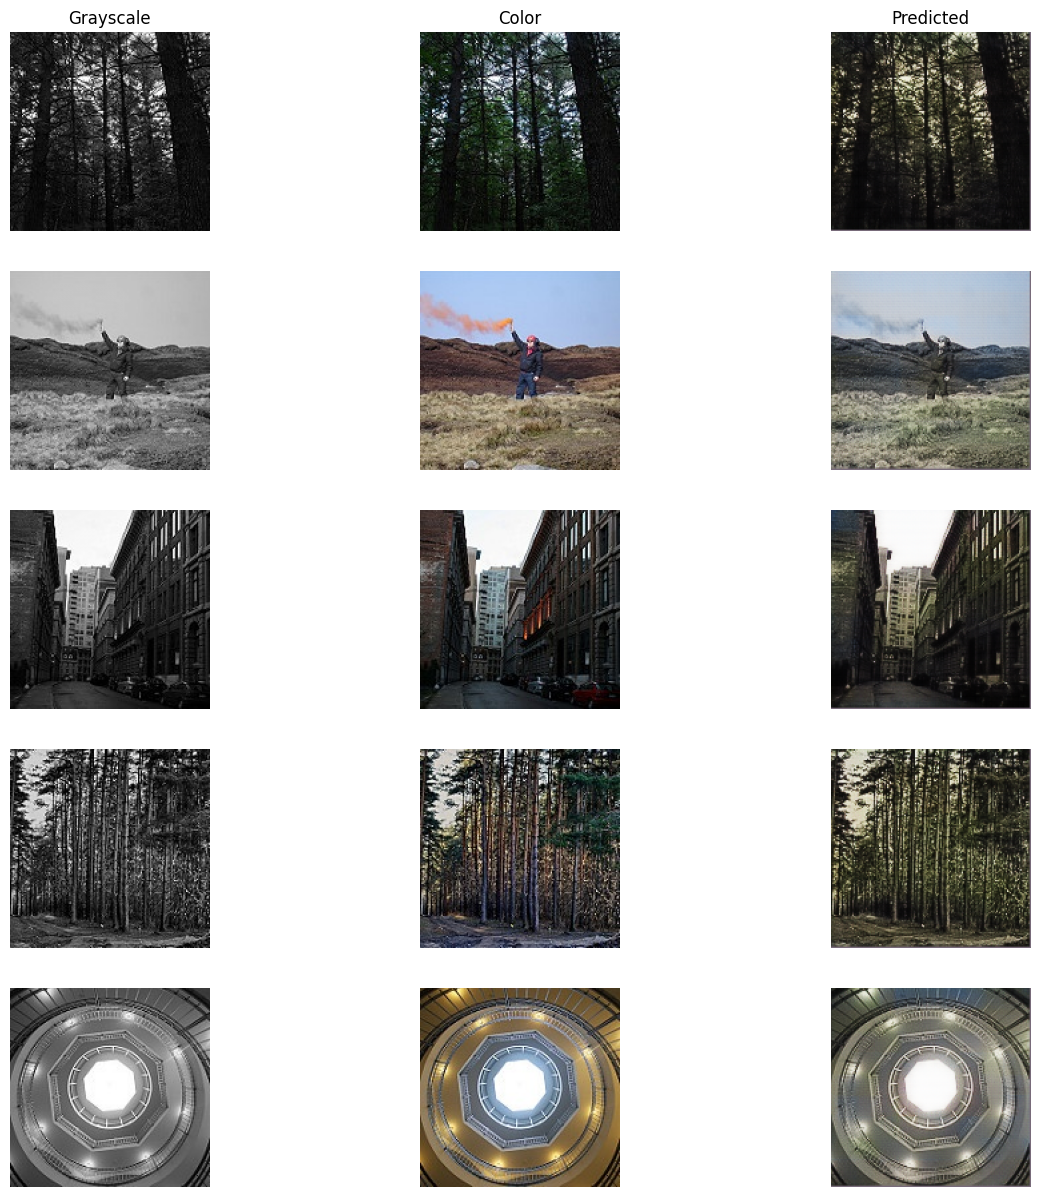

In [19]:
show_predictions(color_img.detach().cpu(), gray_img.detach().cpu(), prediction.detach().cpu(), 5)

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Deep Learning/GreyToColor/colorization_model.pth')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


<ipython-input-20-10bd4c5e10cc>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/Deep Learning/GreyToColor/colorizat

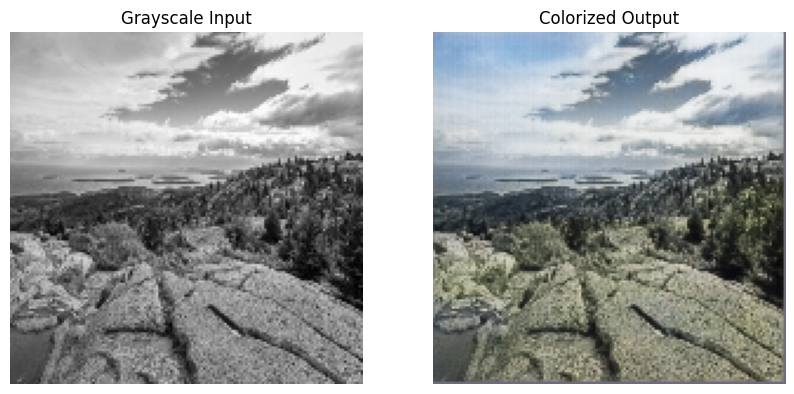

In [20]:
# Load the saved model
model = ColorAutoEncoder().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/Deep Learning/GreyToColor/colorization_model.pth'))
model.eval()

# Load and preprocess the image
image_path = '/content/drive/MyDrive/Deep Learning/GreyToColor/unchecked images/istockphoto-1446618872-612x612.png'
input_image = read_image(image_path) / 255
transform = transforms.Compose([
    transforms.Resize((150, 150), antialias=False),
    transforms.Grayscale()
])
input_tensor = transform(input_image).unsqueeze(0).to(device)


# Make a prediction
with torch.no_grad():
    predicted_image = model(input_tensor)

# Display the original grayscale and the colorized image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Grayscale Input')
plt.imshow(input_tensor.squeeze().cpu(), cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Colorized Output')
plt.imshow(predicted_image.squeeze().permute(1, 2, 0).cpu())
plt.axis('off')

plt.show()

### Trying another Model (Still On Work)

In [26]:
class ModelColorization(nn.Module):
    def __init__(self):
        super(ModelColorization, self).__init__()
        # Input shape: Bx1x150x150


        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1), # 64X150X150
            nn.MaxPool2d(kernel_size=2, stride=2), # 64X75X75
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1), # 32X75X75
            nn.MaxPool2d(kernel_size=2, stride=2), # 32X37X37
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1), # 16X37X37
            nn.MaxPool2d(kernel_size=2, stride=2), # 16X18X18
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Flatten(),
            nn.Linear(16 * 18 * 18, 4000),
        )
        self.decoder = nn.Sequential(
            nn.Linear(4000, 16*18*18),
            nn.ReLU(),
            nn.Unflatten(1, (16, 18, 18)),
            nn.ConvTranspose2d(16, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [27]:
model = ModelColorization().to(device)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Number of trainable parameters of this model are: {total_params:,}")
print(f'\n{model}')

Total Number of trainable parameters of this model are: 41,530,195

ModelColorization(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): ReLU()
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): ReLU()
    (11): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=5184, out_features=4000

In [28]:
for epoch in range(EPOCHS):
    train_loss = train_loop(trainloader, model, criterion, optimizer)
    val_loss = validate_loop(valloader, model, criterion)
    print(f'Epoch: {epoch + 1}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f},')

print('Training And Validate Finished!')

  0%|          | 0/156 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32, 3, 144, 144])) that is different to the input size (torch.Size([32, 3, 150, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (150) must match the size of tensor b (144) at non-singleton dimension 3